# imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# load data and create pandas table

In [2]:
ls *_results

deeprelu_results                        new_targets_results
deeprelu_specializedtarget_results      new_targets_SGD_results
middlelinear_SIM_results                test_specializedtarget_results
middlelinear_specializedtarget_results


In [3]:
res_standard = pd.read_pickle("new_targets_results")
res_deeprelu = pd.read_pickle("deeprelu_results")
res_middlelinear = pd.read_pickle("middlelinear_SIM_results")
print(res_deeprelu.shape,res_standard.shape,res_middlelinear.shape)

(288, 32) (1728, 32) (288, 32)


In [4]:
res_standard[(res_standard.r==1) * (res_standard.sigma<=0.25)].shape

(288, 32)

In [5]:
res = pd.concat([
    res_standard[(res_standard.r==1) * (res_standard.sigma<=0.25)], #filter to just the r and sigma vals we ran everything on
    res_deeprelu[res_deeprelu.L>2], #only look at the actually deep models with these architectures
    res_middlelinear[res_middlelinear.L>2]
])
res.loc[res.L==2,"Activations"] = "Shallow"

In [6]:
res.Activations.unique()

array(['Shallow', 'standard', 'relus', 'middlelinear'], dtype=object)

In [7]:
res.loc[res.Activations == "standard","Activations"] = "Linear Layers then ReLU"
res.loc[res.Activations == "relus","Activations"] = "Deep ReLU"
res.loc[res.Activations == "middlelinear","Activations"] = "ReLU then Linear Layers then ReLU"

In [8]:
res.Activations.unique()

array(['Shallow', 'Linear Layers then ReLU', 'Deep ReLU',
       'ReLU then Linear Layers then ReLU'], dtype=object)

In [9]:
res.shape

(792, 32)

# Check if Final Training Loss is Okay

In [10]:
trainMSE_threshold=1e-2
assert sum(res["Final Train MSE"] >= trainMSE_threshold + res["sigma"]) == 0

In [11]:
res[res["Final Train MSE"] >= trainMSE_threshold + res["sigma"]]["Final Train MSE"]

Series([], Name: Final Train MSE, dtype: float32)

In [12]:
res = res[res["Final Train MSE"] < trainMSE_threshold + res["sigma"]] #filtering out bad fits

# Tuning Hyperparameters

##  determine the lambda parameter that gets the best Validation MSE for each (r,n,L)

In [13]:
validationmse_vs_lambda = res.pivot_table(values="Validation MSE",index = ("r","sigma","n","L","Activations"),columns=["lambda"])
validationmse_vs_lambda

lambda                                             0.00001   0.00010   0.00100
r sigma n    L Activations                                                    
1 0.00  64   2 Shallow                            0.458752  0.030106  0.016170
             3 Deep ReLU                          3.557226  1.450470  0.854816
               Linear Layers then ReLU            0.070858  0.002051  0.018850
               ReLU then Linear Layers then ReLU  3.560966  1.450470  0.854000
             4 Deep ReLU                          4.577781  2.463501  1.821746
...                                                    ...       ...       ...
  0.25  2048 8 Linear Layers then ReLU            0.087193  0.121627  0.062814
               ReLU then Linear Layers then ReLU  0.104669  0.100357  0.095825
             9 Deep ReLU                          0.112632  0.108298  0.099342
               Linear Layers then ReLU            0.177656  0.065273  0.062769
               ReLU then Linear Layers then ReLU  0.104422  0.095309  0.095384

[264 rows x 3 columns]

In [14]:
bestlambda = validationmse_vs_lambda.idxmin(axis=1)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(bestlambda)

r  sigma  n     L  Activations                      
1  0.00   64    2  Shallow                              0.00100
                3  Deep ReLU                            0.00100
                   Linear Layers then ReLU              0.00010
                   ReLU then Linear Layers then ReLU    0.00100
                4  Deep ReLU                            0.00100
                   Linear Layers then ReLU              0.00100
                   ReLU then Linear Layers then ReLU    0.00100
                5  Deep ReLU                            0.00100
                   Linear Layers then ReLU              0.00100
                   ReLU then Linear Layers then ReLU    0.00100
                6  Deep ReLU                            0.00100
                   Linear Layers then ReLU              0.00100
                   ReLU then Linear Layers then ReLU    0.00100
                7  Deep ReLU                            0.00100
                   Linear Layers then ReLU         

In [15]:
mask = [row["lambda"] == bestlambda[row["r"]][row["sigma"]][row["n"]][row["L"]][row["Activations"]] for rowindex,row in res.iterrows()]
res = res[mask]
res

,r,sigma,n,L,lambda,Test MSE,Train MSE,Weight Decay,Learning Rate,Activations,...,Out-of-Distribution Squared Errors,Out-of-Distribution MSE,Out-of-Distribution SEM,Out-of-Distribution STD of Squared Errors,Out-of-Distribution MSE$/\sigma^2$,Gradient Evaluations,Gradient Singular Values,Active Subspace,Active Subspace Distance,Principal Angle (Degrees)
0,1,0.00,64,2,0.0010,0.015114,"[60.264137, 60.159626, 60.055336, 59.95126, 59...","[1340.8088, 1340.6824, 1340.5591, 1340.4393, 1...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",Shallow,...,"[0.060264908, 0.0012339008, 0.021359995, 0.022...",0.740137,0.068111,3.081603,NaN,"[[-0.010868655, 0.09862231, -6.3220673, -1.833...","[968.3287, 11.1431875, 3.0303748, 1.7729315, 1...","[[0.0061678165], [-0.0114117535], [0.5968643],...",0.007630,0.437197
1,1,0.25,64,2,0.0010,0.187302,"[60.19433, 60.09037, 59.986626, 59.883102, 59....","[1340.81, 1340.6852, 1340.564, 1340.4459, 1340...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",Shallow,...,"[1.9390666, 0.7184156, 0.42176837, 0.045139067...",1.495525,0.081860,3.703672,23.928402,"[[0.12141563, 0.108319394, -6.14054, -1.789133...","[946.86957, 21.60087, 14.865539, 12.375286, 10...","[[-0.0046880413], [-0.01742334], [0.5953688], ...",0.046553,2.668235
16,1,0.00,64,3,0.0001,0.001733,"[60.035954, 59.55347, 59.07914, 58.61439, 58.1...","[3341.8418, 3341.9397, 3342.1538, 3342.4817, 3...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",Linear Layers then ReLU,...,"[0.0023075126, 0.00065611483, 0.0020986202, 0....",0.070689,0.006445,0.291602,NaN,"[[-0.059502978, 0.12072323, -6.44347, -1.74740...","[976.60614, 2.477033, 1.1307561, 0.5507929, 0....","[[0.0072736656], [-0.010674082], [0.5981768], ...",0.003006,0.172256
17,1,0.25,64,3,0.0001,0.203769,"[59.957916, 59.476162, 59.002525, 58.53847, 58...","[3341.8403, 3341.936, 3342.1506, 3342.4785, 33...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",Linear Layers then ReLU,...,"[3.3401444, 1.0467758, 0.6155512, 1.4836575, 0...",1.424026,0.056371,2.550415,22.784420,"[[0.0036718221, 0.31535345, -6.5921693, -2.237...","[955.8166, 36.78196, 19.71019, 8.595363, 0.660...","[[-0.0066491887], [-0.010267804], [0.5979431],...",0.050675,2.904684
24,1,0.00,64,4,0.0010,0.000750,"[59.912216, 59.35036, 58.799297, 58.251465, 57...","[6009.612, 6009.445, 6009.598, 6010.0654, 6010...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",Linear Layers then ReLU,...,"[0.0006876053, 0.0009740161, 0.0017763429, 4.7...",0.054110,0.005231,0.236663,NaN,"[[-0.079037204, 0.110973865, -6.4382257, -1.75...","[978.80835, 2.3418548e-05, 1.2861592e-05, 1.00...","[[0.0073431088], [-0.010310258], [0.5981566], ...",0.002165,0.124051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,1,0.00,2048,7,0.0001,0.001567,"[13.457977, 0.51278555, 0.25498796, 0.21393871...","[17984.463, 18032.387, 18023.799, 18018.37, 18...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",ReLU then Linear Layers then ReLU,...,"[9.051344e-05, 0.0049221455, 3.602912e-05, 0.0...",0.006934,0.000340,0.015372,NaN,"[[-0.09068635, 0.105022736, -6.5371037, -1.761...","[974.9033, 3.331135, 3.17138, 2.7776003, 2.734...","[[0.007874297], [-0.01028737], [0.5982255], [0...",0.000412,0.023600
277,1,0.25,2048,8,0.0010,0.098555,"[6.081652, 0.4149643, 0.3475878, 0.25320452, 0...","[23150.99, 23133.229, 23076.855, 23013.225, 22...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",ReLU then Linear Layers then ReLU,...,"[0.09840153, 0.14253546, 0.06879354, 0.0415114...",0.963522,0.090103,4.076600,15.416353,"[[-0.16925263, -0.1510391, -6.419555, -2.12770...","[970.7511, 16.858704, 16.255123, 15.628081, 15...","[[0.0065088486], [-0.009106903], [0.59800345],...",0.005454,0.312468
278,1,0.00,2048,8,0.0001,0.001341,"[6.2126355, 0.35908556, 0.28562617, 0.19064906...","[23310.764, 23338.537, 23329.979, 23321.627, 2...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",ReLU then Linear Layers then ReLU,...,"[1.4741705e-05

##  determine the $L\ge3$ parameter that gets the best validation MSE for each (r,n)

In [16]:
validationmse_vs_L = res.pivot_table(values="Validation MSE",index = ("r","sigma","n","Activations"),columns=["L"])
validationmse_vs_L = validationmse_vs_L.iloc[:,1:]
validationmse_vs_L

L                                                      3         4         5  \
r sigma n    Activations                                                       
1 0.00  64   Deep ReLU                          0.854816  1.821746  1.917755   
             Linear Layers then ReLU            0.002051  0.000932  0.000715   
             ReLU then Linear Layers then ReLU  0.854000  1.230832  1.735846   
             Shallow                                 NaN       NaN       NaN   
        128  Deep ReLU                          0.039911  0.268970  0.628970   
             Linear Layers then ReLU            0.000425  0.000206  0.000129   
             ReLU then Linear Layers then ReLU  0.039944  0.055320  0.312463   
             Shallow                                 NaN       NaN       NaN   
        256  Deep ReLU                          0.013024  0.011561  0.010032   
             Linear Layers then ReLU            0.000193  0.000064  0.000044   
             ReLU then Linear Layers then ReLU  0.013103  0.013675  0.015878   
             Shallow                                 NaN       NaN       NaN   
        512  Deep ReLU                          0.011146  0.007136  0.007011   
             Linear Layers then ReLU            0.000141  0.000071  0.000049   
             ReLU then Linear Layers then ReLU  0.011100  0.004035  0.007318   
             Shallow                                 NaN       NaN       NaN   
        1024 Deep ReLU                          0.006594  0.004091  0.003364   
             Linear Layers then ReLU            0.000167  0.000080  0.000056   
             ReLU then Linear Layers then ReLU  0.006594  0.001937  0.002834   
             Shallow                                 NaN       NaN       NaN   
        2048 Deep ReLU                          0.002843  0.002556  0.001670   
             Linear Layers then ReLU            0.000036  0.000024  0.000016   
             ReLU then Linear Layers then ReLU  0.003150  0.000355  0.001383   
             Shallow                                 NaN       NaN       NaN   
  0.25  64   Deep ReLU                          1.096567  2.015968  2.166481   
             Linear Layers then ReLU            0.224697  0.185447  0.255699   
             ReLU then Linear Layers then ReLU  1.099366  1.530103  2.127420   
             Shallow                                 NaN       NaN       NaN   
        128  Deep ReLU                          0.259919  0.537597  0.773923   
             Linear Layers then ReLU            0.148188  0.133400  0.163496   
             ReLU then Linear Layers then ReLU  0.259919  0.304765  0.584615   
             Shallow                                 NaN       NaN       NaN   
        256  Deep ReLU                          0.142377  0.156556  0.181930   
             Linear Layers then ReLU            0.122988  0.113307  0.112297   
             ReLU then Linear Layers then ReLU  0.140188  0.139640  0.153381   
             Shallow                                 NaN       NaN       NaN   
        512  Deep ReLU                          0.123901  0.139294  0.146497   
             Linear Layers then ReLU            0.107883  0.102970  0.101477   
             ReLU then Linear Layers then ReLU  0.123102  0.131915  0.131820   
             Shallow                                 NaN       NaN       NaN   
        1024 Deep ReLU                          0.103863  0.104340  0.109712   
             Linear Layers then ReLU            0.089619  0.092375  0.091105   
             ReLU then Linear Layers then ReLU  0.105459  0.107146  0.105053   
             Shallow                                 NaN       NaN       NaN   
        2048 Deep ReLU                          0.088631  0.091126  0.091803   
             Linear Layers then ReLU            0.080262  0.083260  0.078215   
             ReLU then Linear Layers then ReLU  0.091565  0.093982  0.093036   
             Shallow                                 NaN       NaN       NaN   


In [17]:
bestL = validationmse_vs_L.idxmin(axis=1)
bestL

/tmp/ipykernel_755802/27839364.py:1: FutureWarning: The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  bestL = validationmse_vs_L.idxmin(axis=1)


r  sigma  n     Activations                      
1  0.00   64    Deep ReLU                            3.0
                Linear Layers then ReLU              9.0
                ReLU then Linear Layers then ReLU    3.0
                Shallow                              NaN
          128   Deep ReLU                            3.0
                Linear Layers then ReLU              5.0
                ReLU then Linear Layers then ReLU    3.0
                Shallow                              NaN
          256   Deep ReLU                            8.0
                Linear Layers then ReLU              5.0
                ReLU then Linear Layers then ReLU    7.0
                Shallow                              NaN
          512   Deep ReLU                            9.0
                Linear Layers then ReLU              9.0
                ReLU then Linear Layers then ReLU    8.0
                Shallow                              NaN
          1024  Deep ReLU             

In [18]:
mask = [row["L"] == bestL[row["r"]][row["sigma"]][row["n"]][row["Activations"]] for rowindex,row in res.iterrows()]
bestLres = res[mask]

In [19]:
bestLres.sort_values(by=['r','n',"sigma","Activations"])

,r,sigma,n,L,lambda,Test MSE,Train MSE,Weight Decay,Learning Rate,Activations,...,Out-of-Distribution Squared Errors,Out-of-Distribution MSE,Out-of-Distribution SEM,Out-of-Distribution STD of Squared Errors,Out-of-Distribution MSE$/\sigma^2$,Gradient Evaluations,Gradient Singular Values,Active Subspace,Active Subspace Distance,Principal Angle (Degrees)
6,1,0.00,64,3,0.00100,0.795682,"[60.090473, 59.553192, 59.022366, 58.497612, 5...","[3341.178, 3340.6357, 3340.227, 3339.9487, 333...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",Deep ReLU,...,"[1.0115689, 0.0804351, 0.54664594, 13.374668, ...",5.111322,0.252640,11.430382,NaN,"[[-0.7693236, -0.4344431, -5.1449265, -1.48665...","[903.03674, 80.3996, 28.027071, 27.071205, 19....","[[0.0054033543], [-0.0191272], [0.60186476], [...",0.067765,3.885600
84,1,0.00,64,9,0.00100,0.000463,"[60.210335, 60.043922, 59.794342, 59.418682, 5...","[29308.39, 29269.043, 29236.047, 29209.574, 29...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",Linear Layers then ReLU,...,"[0.00019819403, 0.0025573983, 0.0011131126, 2....",0.004198,0.000324,0.014646,NaN,"[[-0.085160956, 0.11539366, -6.4720883, -1.769...","[979.85034, 2.272786e-05, 1.4584952e-05, 1.141...","[[0.007867969], [-0.0106611485], [0.5979522], ...",0.001968,0.112734
6,1,0.00,64,3,0.00100,0.795789,"[60.090473, 59.553196, 59.022366, 58.497612, 5...","[3341.178, 3340.6357, 3340.227, 3339.9487, 333...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",ReLU then Linear Layers then ReLU,...,"[1.0104489, 0.07830228, 0.5514115, 13.371166, ...",5.115656,0.252644,11.430586,NaN,"[[-0.75817186, -0.4238171, -5.1476116, -1.4727...","[902.673, 79.87848, 28.042547, 26.8707, 19.042...","[[0.005137328], [-0.01939041], [0.602143], [0....",0.068209,3.911106
7,1,0.25,64,3,0.00100,1.003407,"[60.01524, 59.480907, 58.952995, 58.43115, 57....","[3341.1697, 3340.6235, 3340.2175, 3339.9417, 3...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",Deep ReLU,...,"[3.0955064, 0.47768694, 1.2210367, 15.464828, ...",5.712784,0.256239,11.593235,91.404541,"[[-0.64062434, -0.3422928, -4.8385406, -1.6422...","[893.38007, 80.438545, 37.447884, 26.624731, 2...","[[0.006190156], [0.021741752], [-0.59804666], ...",0.091533,5.251806
25,1,0.25,64,4,0.00100,0.176464,"[59.835785, 59.27438, 58.723824, 58.17633, 57....","[6009.62, 6009.4595, 6009.6147, 6010.085, 6010...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",Linear Layers then ReLU,...,"[0.4667347, 0.04215371, 0.12199344, 0.18785368...",0.689151,0.024729,1.118811,11.026415,"[[0.020501085, -0.05495558, -5.830973, -1.6566...","[966.2452, 47.81836, 17.55743, 2.7263505, 6.84...","[[-0.006823213], [-0.012062298], [0.5975432], ...",0.040257,2.307153
7,1,0.25,64,3,0.00100,1.004314,"[60.01524, 59.480907, 58.952995, 58.43115, 57....","[3341.1697, 3340.6235, 3340.2175, 3339.9417, 3...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",ReLU then Linear Layers then ReLU,...,"[3.1349747, 0.45143974, 1.2333804, 15.450279, ...",5.720018,0.256396,11.600340,91.520294,"[[-0.6384168, -0.34309945, -4.8186855, -1.6589...","[893.2937, 80.36163, 37.60496, 27.533655, 20.8...","[[0.0061157886], [0.021653714], [-0.5979719], ...",0.091528,5.251537
54,1,0.00,128,3,0.00100,0.033449,"[49.122738, 48.30033, 47.49201, 46.693417, 45....","[3340.5862, 3340.0132, 3339.9084, 3340.2136, 3...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",Deep ReLU,...,"[0.0006858059, 0.0020395382, 0.0045566517, 0.0...",2.260104,0.213135,9.643046,NaN,"[[-0.12882328, 0.08184438, -6.3161, -1.8045845...","[966.31305, 8.0987425, 5.4513383, 4.8641295, 4...","[[0.0063798544], [-0.010559826], [0.5981811], ...",0.006179,0.354038
136,1,0.00,128,5,0.00010,0.000121,"[48.925003, 48.27504, 47.552925, 46.661526, 45...","[9343.715, 9345.677, 9349.422, 9354.756, 9361....","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",Linear Layers then ReLU,...,"[2.8298095e-05, 0.00043059408, 0.00035353936, ...",0.005129,0.000503,0.022736,NaN,"[[-0.08770336, 0.11391217, -6.47798

## What are the chosen lambda and L for each model?

In [20]:
bestres = pd.concat((res[res["L"] == 2],bestLres))

In [21]:
print(bestres.pivot_table(index=["r","sigma","n","Activations","L"],values=["lambda"]).shape)
bestres.pivot_table(index=["r","sigma","n","Activations","L"],values=["lambda"])

(48, 1)


lambda
r sigma n    Activations                       L         
1 0.00  64   Deep ReLU                         3  0.00100
             Linear Layers then ReLU           9  0.00100
             ReLU then Linear Layers then ReLU 3  0.00100
             Shallow                           2  0.00100
        128  Deep ReLU                         3  0.00100
             Linear Layers then ReLU           5  0.00010
             ReLU then Linear Layers then ReLU 3  0.00100
             Shallow                           2  0.00100
        256  Deep ReLU                         8  0.00100
             Linear Layers then ReLU           5  0.00010
             ReLU then Linear Layers then ReLU 7  0.00100
             Shallow                           2  0.00100
        512  Deep ReLU                         9  0.00100
             Linear Layers then ReLU           9  0.00001
             ReLU then Linear Layers then ReLU 8  0.00100
             Shallow                           2  0.00010
        1024 Deep ReLU                         7  0.00010
             Linear Layers then ReLU           8  0.00001
             ReLU then Linear Layers then ReLU 4  0.00010
             Shallow                           2  0.00010
        2048 Deep ReLU                         9  0.00010
             Linear Layers then ReLU           8  0.00001
             ReLU then Linear Layers then ReLU 4  0.00010
             Shallow                           2  0.00010
  0.25  64   Deep ReLU                         3  0.00100
             Linear Layers then ReLU           4  0.00100
             ReLU then Linear Layers then ReLU 3  0.00100
             Shallow                           2  0.00100
        128  Deep ReLU                         3  0.00100
             Linear Layers then ReLU           4  0.00100
             ReLU then Linear Layers then ReLU 3  0.00100
             Shallow                           2  0.00100
        256  Deep ReLU                         3  0.00100
             Linear Layers then ReLU           7  0.00001
             ReLU then Linear Layers then ReLU 4  0.00100
             Shallow                           2  0.00100
        512  Deep ReLU                         3  0.00100
             Linear Layers then ReLU           9  0.00100
             ReLU then Linear Layers then ReLU 3  0.00100
             Shallow                           2  0.00100
        1024 Deep ReLU                         3  0.00100
             Linear Layers then ReLU           9  0.00100
             ReLU then Linear Layers then ReLU 6  0.00010
             Shallow                           2  0.00100
        2048 Deep ReLU                         3  0.00100
             Linear Layers then ReLU           9  0.00100
             ReLU then Linear Layers then ReLU 3  0.00100
             Shallow                           2  0.00100

# Plotting

In [22]:
fontname = "Times New Roman"
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

## Plots of L vs Validation error

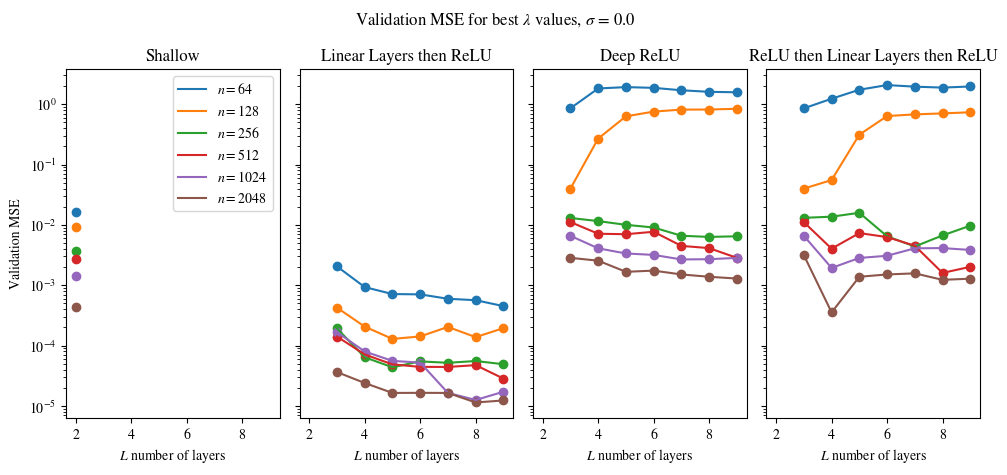

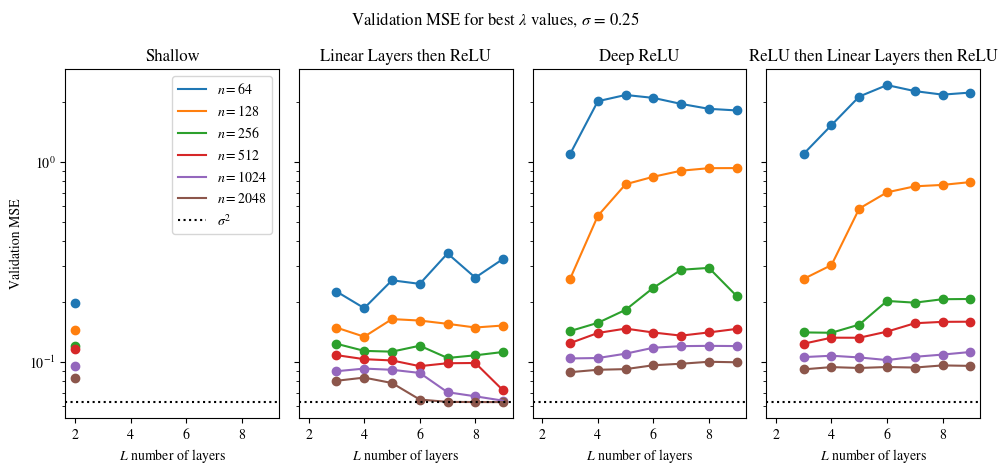

In [23]:
for std in res.sigma.unique():
    f, ax = plt.subplots(ncols=len(res.Activations.unique()),nrows=1, sharex=True, sharey=True, figsize=(10,4.8))
    for col,activation in enumerate(res.Activations.unique()):
        for n in res.n.unique():
                res_rnstd = res[(res.n == n) * (res["sigma"] == std) * (res.Activations == activation)]
                ax[col].scatter(res_rnstd.L,res_rnstd[["Validation MSE"]])
                ax[col].semilogy(res_rnstd.L,res_rnstd[["Validation MSE"]],label=rf"$n={n}$")
                for _,model in res_rnstd.iterrows():
                    text = rf'$\lambda = {model["lambda"]:.0e}$' + f'\nfit {model["Final Train MSE"]:.1e}\nwd{model["Final Weight Decay"]:.1e}'
        ax[col].set_xlabel("$L$ number of layers")
        ax[col].set_title(activation)
        if std > 0:
            ax[col].axhline(y=std**2, color='k', linestyle=':',label="$\sigma^2$")
        ax[0].set_ylabel("Validation MSE")
        f.suptitle(rf"Validation MSE for best $\lambda$ values, $\sigma$ = {std}")
    ax[0].legend()
    f.tight_layout()
    if int(std) == std:
        std = int(std)
    f.savefig("architecture_comparison"+f"_labelnoise{std}_ValidationMSE.pdf",dpi=300)
    plt.show()

## Performance metrics with/without linear layers

In [24]:
res.r.unique()

array([1])

In [25]:
res.Activations.unique()

array(['Shallow', 'Linear Layers then ReLU', 'Deep ReLU',
       'ReLU then Linear Layers then ReLU'], dtype=object)

In [26]:
columnwidth = 6.17406722223
markersize = 4
colors = {  
    0   :"C0",
    0.25:"C1",
}
linestyles = {
    "Shallow":"-",
    "Linear Layers then ReLU":"--",
    'Deep ReLU':"-.",
    'ReLU then Linear Layers then ReLU':(0, (3, 1, 1, 1, 1, 1))
}
markers = {
    "Shallow":".",
    "Linear Layers then ReLU":"x",
    'Deep ReLU':"^",
    'ReLU then Linear Layers then ReLU':"v"
}

### generalization

(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)


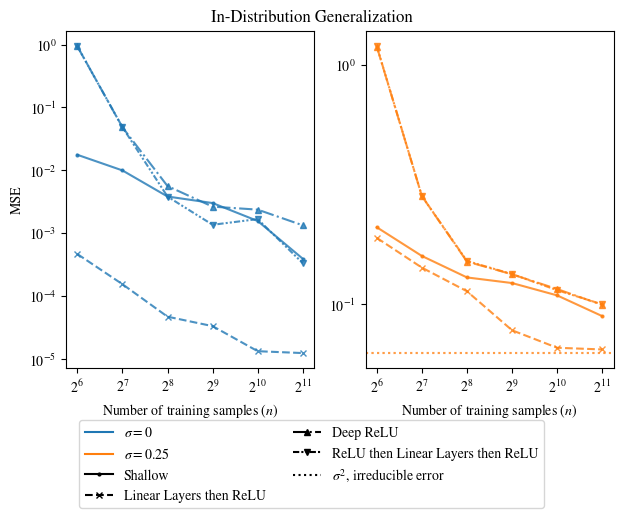

(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)


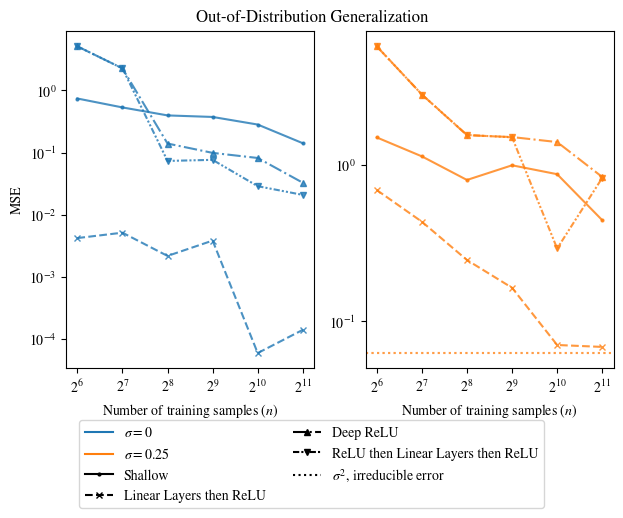

In [27]:
#generalization and OOD errors
handles = [
    Line2D([0], [0], color=color, ls='-', label=rf"$\sigma =${sigma}") for sigma,color in colors.items()
]
handles += [
    Line2D([0], [0], color='k', ls=linestyles[activation], label=activation, marker = markers[activation], markersize=markersize) for activation in res.Activations.unique()
] 
handles += [
        Line2D([0], [0], color='k', ls=':', label='$\sigma^2$, irreducible error'),
]

for metric in ['In-Distribution','Out-of-Distribution']:
    standard_errors = metric[:-3] + 'SEM'
    f, ax = plt.subplots(ncols=2,nrows=1, sharex=True, figsize=(columnwidth,4.25))
    #just the data without label noise in the first row
    for col,sigma in enumerate([0,0.25]):
        for activation in res.Activations.unique():
            curr = bestres[(bestres.Activations == activation) * (bestres.sigma == sigma)]
            print(curr.shape)
            points = curr[[metric + " MSE"]].values[:,0]
            ax[col].plot(curr.n,points,
                                linestyle=linestyles[activation],
                                marker=markers[activation],
                                markersize=markersize,
                                color=colors[sigma],
                                alpha=0.8)
            #horizontal dashed line for minimal possible MSE (ie sigma^2) in plots with label noise
            ax[1].axhline(y=sigma**2, color=colors[sigma], linestyle=':',alpha=0.3)
        #plot set up
        ax[col].set_xscale("log",base=2)
        ax[col].set_xticks([2**k for k in range(6,12)])
        ax[col].set_yscale("log",base=10)
        ax[0].set_ylabel(f"MSE",wrap=True)
        ax[col].set_xlabel("Number of training samples ($n$)")
        ax[col].minorticks_off()
    f.legend(handles=handles, ncol=2, loc = 'upper center', bbox_to_anchor=(0.5,0.03))
    plt.suptitle(f"{metric} Generalization")
    plt.tight_layout(pad=0.5,h_pad=1.08, w_pad=1.08)
    plt.savefig("architecture_comparison"+f"{metric} Generalization.pdf",dpi=300,bbox_inches='tight')
    plt.show()

### singular values

Shallow 0.0 64
Linear Layers then ReLU 0.0 64
Deep ReLU 0.0 64
ReLU then Linear Layers then ReLU 0.0 64
Shallow 0.25 64
Linear Layers then ReLU 0.25 64
Deep ReLU 0.25 64
ReLU then Linear Layers then ReLU 0.25 64
Shallow 0.0 128
Linear Layers then ReLU 0.0 128
Deep ReLU 0.0 128
ReLU then Linear Layers then ReLU 0.0 128
Shallow 0.25 128
Linear Layers then ReLU 0.25 128
Deep ReLU 0.25 128
ReLU then Linear Layers then ReLU 0.25 128
Shallow 0.0 256
Linear Layers then ReLU 0.0 256
Deep ReLU 0.0 256
ReLU then Linear Layers then ReLU 0.0 256
Shallow 0.25 256
Linear Layers then ReLU 0.25 256
Deep ReLU 0.25 256
ReLU then Linear Layers then ReLU 0.25 256
Shallow 0.0 512
Linear Layers then ReLU 0.0 512
Deep ReLU 0.0 512
ReLU then Linear Layers then ReLU 0.0 512
Shallow 0.25 512
Linear Layers then ReLU 0.25 512
Deep ReLU 0.25 512
ReLU then Linear Layers then ReLU 0.25 512
Shallow 0.0 1024
Linear Layers then ReLU 0.0 1024
Deep ReLU 0.0 1024
ReLU then Linear Layers then ReLU 0.0 1024
Shallow 0.25 102

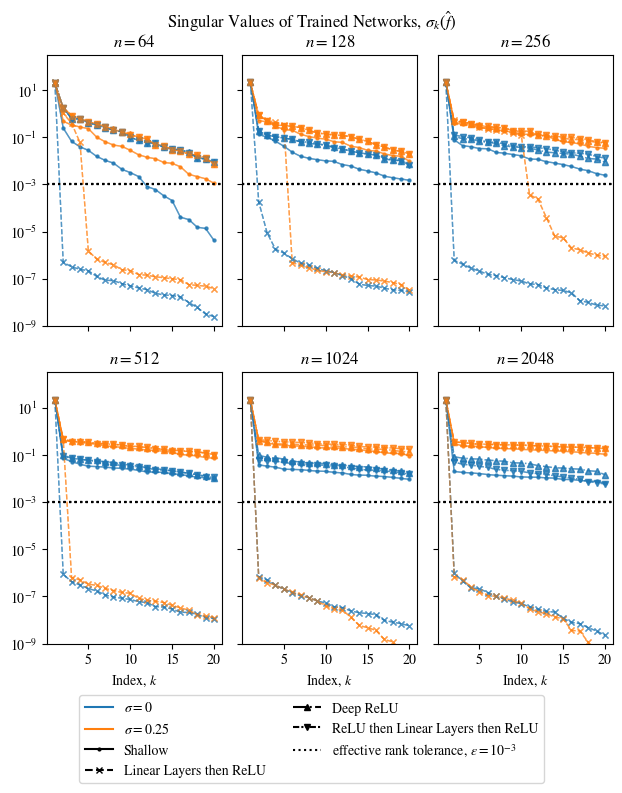

In [28]:
handles = [
    Line2D([0], [0], color=color, ls='-', label=rf"$\sigma =${sigma}") for sigma,color in colors.items()
]
handles += [
    Line2D([0], [0], color='k', ls=linestyles[activation], label=activation, marker = markers[activation], markersize=markersize) for activation in res.Activations.unique()
] 
handles += [Line2D([0], [0], color='k', ls=':', label=r"effective rank tolerance, $\varepsilon = 10^{-3}$")]

ranktol = 1e-3
f, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(columnwidth,7))#,5.75))
for activation in res.Activations.unique():
    for nnum,n in enumerate(res.n.unique()):
        row = nnum // 3
        col = nnum % 3
        for sigma in res.sigma.unique():
            for activation in res.Activations.unique():
                print(activation,sigma,n)
                curr = bestres[(bestres.Activations == activation) * (bestres.sigma == sigma) * (bestres.n == n)]
                ax[row,col].semilogy(curr["Gradient Singular Values"].values[0]/np.sqrt(2048),
                    linestyle=linestyles[activation],
                    linewidth=1,
                    alpha=0.3,
                    marker=markers[activation],
                    markersize=markersize,
                    color=colors[sigma])
        ax[row,col].axhline(y=ranktol, color='k', linestyle=':',alpha=1, label = r"effective rank tolerance, $\varepsilon = 10^{-3}$")
        ax[row,col].set_xticks(list(range(4,20,5)),list(range(5,21,5)))
        ax[0,0].set_yticks([10**p for p in range(-9,3,2)])
        ax[row,col].set_title(rf"$n={n}$")
        ax[-1,col].set_xlabel(rf"Index, $k$")
        ax[row,col].set_ylim(10**(-9),10**(2.5))
f.legend(handles=handles, ncol=2, loc = 'upper center', bbox_to_anchor=(0.5,0.01))
plt.suptitle(r"Singular Values of Trained Networks, $\sigma_k(\hat{f})$")
plt.tight_layout(pad=0.5,h_pad=1.08, w_pad=1.08)
plt.savefig("architecture_comparison"+f"_labelnoise_sv.pdf",dpi=300, bbox_inches='tight')
plt.show()
handles.pop()

### active subspaces

0.0
0.25
0.0
0.25


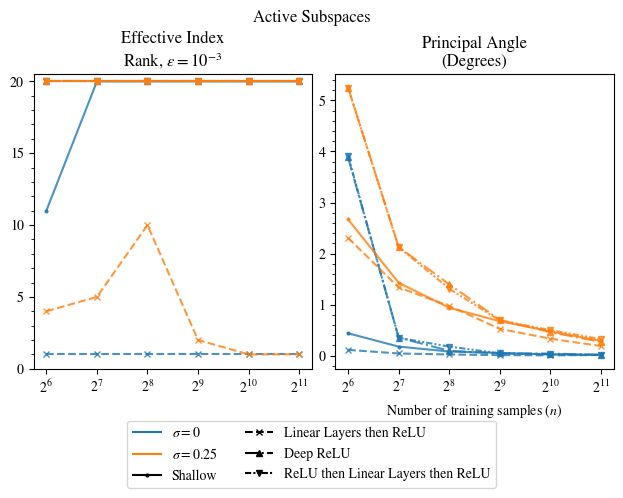

In [29]:
handles = [
    Line2D([0], [0], color=color, ls='-', label=rf"$\sigma =${sigma}") for sigma,color in colors.items()
]
handles += [
    Line2D([0], [0], color='k', ls=linestyles[activation], label=activation, marker = markers[activation], markersize=markersize) for activation in res.Activations.unique()
] 

#active subspace error plot
f, ax = plt.subplots(ncols=2,nrows=1, sharex=True, sharey=False, figsize=(columnwidth,4.25))
for col,metric in enumerate([r"Effective Index Rank, $\varepsilon = 10^{-3}$","Principal Angle (Degrees)"]):
    for sigma in res.sigma.unique():
        print(sigma)
        for activation in res.Activations.unique():
            curr = bestres[(bestres.Activations == activation) * (bestres.sigma == sigma)]
            if metric == "Principal Angle (Degrees)":
                points = curr[[metric]].values[:,0]
            elif metric == r"Effective Index Rank, $\varepsilon = 10^{-3}$":
                points = (np.array(curr["Gradient Singular Values"].tolist())/np.sqrt(2048) > ranktol).sum(axis=1)
                ax[col].set_yticks(np.arange(0,21,5))
                ax[col].set_ylim(0,20.5)
            ax[col].plot(curr.n,points,
                                linestyle=linestyles[activation],
                                color=colors[sigma],
                                marker=markers[activation],
                                markersize=markersize,
                                alpha=0.8)
    #plot set up
    ax[col].set_title(metric[:15] + '\n' + metric[16:])
    ax[0].set_yticks(range(21), minor=True)
    ax[col].set_xscale("log",base=2)
    ax[col].set_xticks([2**k for k in range(6,12)])
    ax[1].set_xlabel("Number of training samples ($n$)")
    ax[col].minorticks_on()
f.legend(handles=handles, ncol=2, loc = 'upper center', bbox_to_anchor=(0.5,0.03))
plt.suptitle(f"Active Subspaces")
plt.tight_layout(pad=0.5,h_pad=0.5, w_pad=0.5)
plt.savefig("architecture_comparison"+f"Active Subspaces.pdf",dpi=300,bbox_inches='tight')
plt.show()

## training

Shallow 0.0 64
Linear Layers then ReLU 0.0 64
Deep ReLU 0.0 64
ReLU then Linear Layers then ReLU 0.0 64
Shallow 0.25 64
Linear Layers then ReLU 0.25 64
Deep ReLU 0.25 64
ReLU then Linear Layers then ReLU 0.25 64
Shallow 0.0 128
Linear Layers then ReLU 0.0 128
Deep ReLU 0.0 128
ReLU then Linear Layers then ReLU 0.0 128
Shallow 0.25 128
Linear Layers then ReLU 0.25 128
Deep ReLU 0.25 128
ReLU then Linear Layers then ReLU 0.25 128
Shallow 0.0 256
Linear Layers then ReLU 0.0 256
Deep ReLU 0.0 256
ReLU then Linear Layers then ReLU 0.0 256
Shallow 0.25 256
Linear Layers then ReLU 0.25 256
Deep ReLU 0.25 256
ReLU then Linear Layers then ReLU 0.25 256
Shallow 0.0 512
Linear Layers then ReLU 0.0 512
Deep ReLU 0.0 512
ReLU then Linear Layers then ReLU 0.0 512
Shallow 0.25 512
Linear Layers then ReLU 0.25 512
Deep ReLU 0.25 512
ReLU then Linear Layers then ReLU 0.25 512
Shallow 0.0 1024
Linear Layers then ReLU 0.0 1024
Deep ReLU 0.0 1024
ReLU then Linear Layers then ReLU 0.0 1024
Shallow 0.25 102

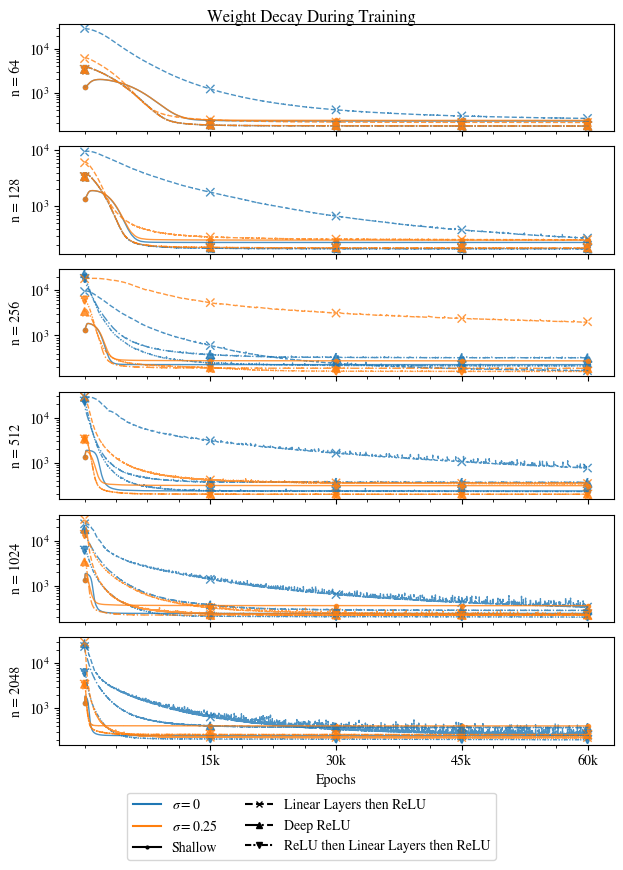

Shallow 0.0 64
Linear Layers then ReLU 0.0 64
Deep ReLU 0.0 64
ReLU then Linear Layers then ReLU 0.0 64
Shallow 0.25 64
Linear Layers then ReLU 0.25 64
Deep ReLU 0.25 64
ReLU then Linear Layers then ReLU 0.25 64
Shallow 0.0 128
Linear Layers then ReLU 0.0 128
Deep ReLU 0.0 128
ReLU then Linear Layers then ReLU 0.0 128
Shallow 0.25 128
Linear Layers then ReLU 0.25 128
Deep ReLU 0.25 128
ReLU then Linear Layers then ReLU 0.25 128
Shallow 0.0 256
Linear Layers then ReLU 0.0 256
Deep ReLU 0.0 256
ReLU then Linear Layers then ReLU 0.0 256
Shallow 0.25 256
Linear Layers then ReLU 0.25 256
Deep ReLU 0.25 256
ReLU then Linear Layers then ReLU 0.25 256
Shallow 0.0 512
Linear Layers then ReLU 0.0 512
Deep ReLU 0.0 512
ReLU then Linear Layers then ReLU 0.0 512
Shallow 0.25 512
Linear Layers then ReLU 0.25 512
Deep ReLU 0.25 512
ReLU then Linear Layers then ReLU 0.25 512
Shallow 0.0 1024
Linear Layers then ReLU 0.0 1024
Deep ReLU 0.0 1024
ReLU then Linear Layers then ReLU 0.0 1024
Shallow 0.25 102

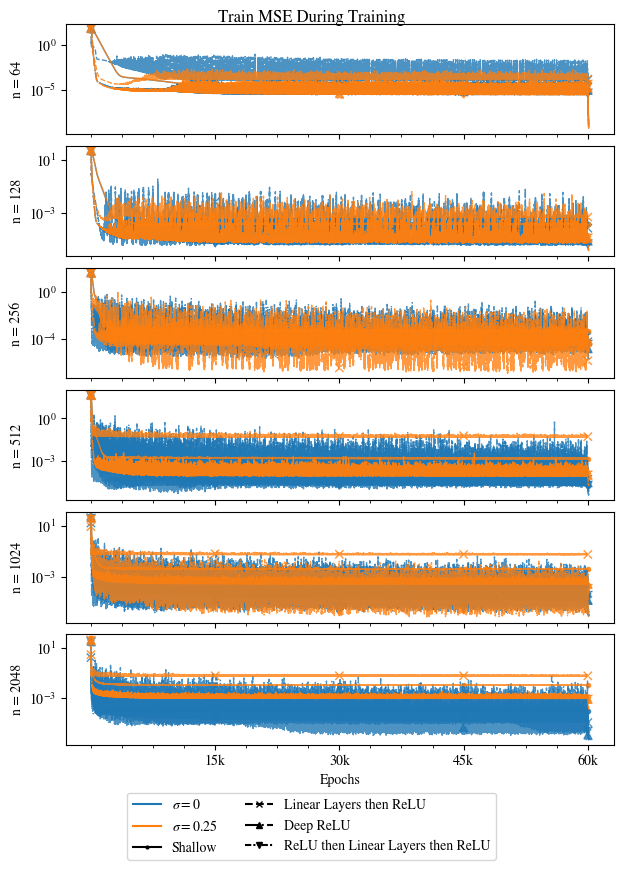

In [30]:
handles = [
    Line2D([0], [0], color=color, ls='-', label=rf"$\sigma =${sigma}") for sigma,color in colors.items()
]
handles += [
    Line2D([0], [0], color='k', ls=linestyles[activation], label=activation, marker = markers[activation], markersize=markersize) for activation in res.Activations.unique()
] 

#training time plot
for metric in ["Weight Decay","Train MSE"]:
    f, ax = plt.subplots(nrows=len(res.n.unique()), sharex=True, sharey=False, figsize=(columnwidth,8))
    for row,n in enumerate(res.n.unique()):
        for sigma in res.sigma.unique():
            for activation in res.Activations.unique():
                curr = bestres[(bestres.Activations == activation) * (bestres.sigma == sigma) * (bestres.n == n)]
                print(activation,sigma,n)
                assert curr[metric].shape[0] == 1 # make sure there's only one row
                values_to_plot = curr[metric].iloc[0]
                epochs = len(values_to_plot)
                ax[row].plot(np.arange(epochs),values_to_plot,
                                    linestyle=linestyles[activation],
                                    color=colors[sigma],
                                    linewidth = 1,
                                    alpha=0.8)
                ax[row].scatter(np.arange(epochs)[::15_000],values_to_plot[::15_000],
                                    linestyle=linestyles[activation],
                                    color=colors[sigma],
                                    marker=markers[activation],
                                    linewidth = 1,
                                    alpha=0.8)
            #plot set up
            ax[row].set_ylabel(f"n = {n}")
            ax[row].set_yscale("log",base=10)
            ax[row].minorticks_on()
            ax[-1].set_xlabel("Epochs")
            ticks = np.arange(15_000,epochs,step=15_000)
            ax[-1].set_xticks(ticks=ticks, labels=[str(t)[:-3]+'k' for t in ticks])
    f.legend(handles=handles, ncol=2, loc = 'upper center', bbox_to_anchor=(0.5,0.01))
    plt.suptitle(metric+" During Training")
    plt.tight_layout(pad=0.5,h_pad=0.5, w_pad=0.5)
    plt.savefig("architecture_comparison"+metric+"training.pdf",dpi=300,bbox_inches='tight')
    plt.show()